In [56]:
import numpy as np
np.random.seed(5)

import matplotlib.pyplot as plt

import pandas as pd
import datetime


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras

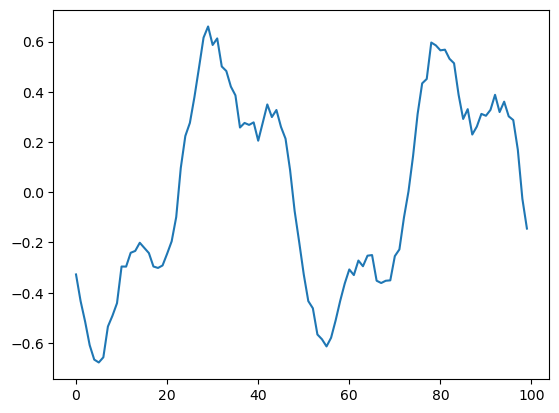

In [57]:
def generate_time_serie(n_steps):
    """Genera 4 números aleatorios

    Args:
        n_steps (int): El Nº De pasos

    Returns:
        serie: Una serie de Floats
    """
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, 1)
    time = np.linspace(0, 1, n_steps)
    serie = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    serie += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    serie += 0.1 * (np.random.rand(n_steps) - 0.5)   # + noise
    return serie.astype(np.float32)

n_steps = 100
s1 = generate_time_serie(n_steps)

# Utilizaremos esto como una serie para el modelo (Simulando que sea bolsa)
plt.plot(s1)

In [58]:
def genera_train(serie,lg_secuencia,lg_y):
    """Genera el set de entrenamiento

    Args:
        serie (pd.Serie): Serie de datos
        lg_secuencia (int): Longitud de la secuencia
        lg_y (int): Longitud de los datos recogidos
    """
    # Imaginemos que es de 20 entonces será 1000 - 20 - los valores que vamos recoger
    x=[]
    y=[]
    ultimo = len(serie)-lg_secuencia-lg_y
    for ix in range(ultimo):
      x.append(serie[ix:ix+lg_secuencia])
      y.append(serie[ix+lg_secuencia:ix+lg_secuencia+lg_y])
    return np.array(x), np.array(y)


# Generamos los train y test

In [59]:
lg_sec = 50
x, y = genera_train(s1, lg_sec, 1)
limite = int(len(x) * 0.8)
X_train, y_train = x[:limite], y[:limite]
X_test, y_test = x[limite:], y[limite:]


In [60]:
X_train.shape

(39, 50)

In [61]:
def plot_serie(serie, lg_sec, y, y_pred ):
  fig=plt.figure(figsize=(15,5))
  plt.plot(serie)
  plt.plot(lg_sec, y, "bo")
  plt.plot(lg_sec, y_pred, "rx")

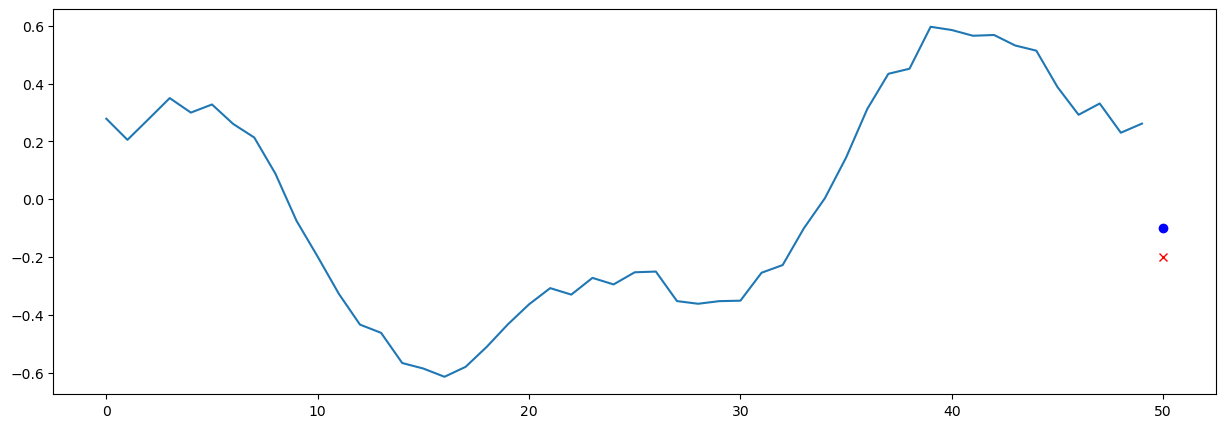

In [62]:
plot_serie(X_test[0], lg_sec, -0.1, -0.2)

Vamos a decirle que la "predicción" sea igual al punto

In [63]:
def modelo_predice_igual_ultimo(x):
  ret = []
  for e in x:
    ret.append(e[-1])
  return ret

Decimos que la y_pred sea el último valor de X_train

rms modelo_predice_igual_ultimo = 0.08301575481891632


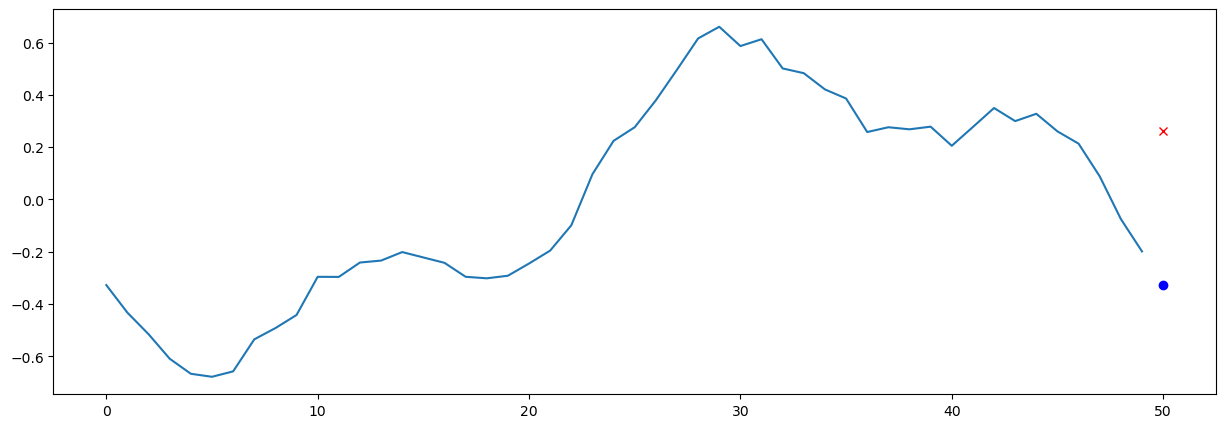

In [64]:
y_pred = modelo_predice_igual_ultimo(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_predice_igual_ultimo = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Modelo de Regresión Líneal Estadístico

In [65]:
def modelo_regresion_lineal(x):
    """Crea un modelo de regresión Lineal donde
    Sus X es cada uno de los valores de 0-len(e) en una lista y
    Sus Y es cada uno de los valores de 0-len(e) donde se recoge el index de ese for en e

    Args:
        x (int): Epochs

    Returns:
        int: Predicciones del modelo concatenadas
    """
    ret = []
    for e in x:
      regresor = LinearRegression()
      vx = [[i] for i in range(len(e))]
      vy = [[e[i]] for i in range(len(e))]
    
      regresor.fit(vx, vy)
      r1 = regresor.predict([[len(e)]])
      ret.append(r1)
    ret = np.concatenate(ret)
    return ret

rms modelo_regresion_lineal = 0.23966081491032293


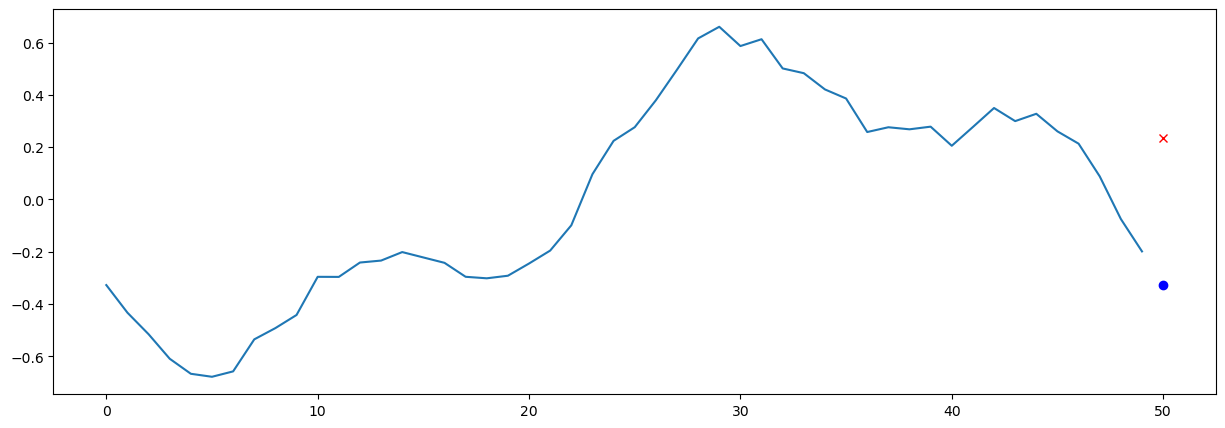

In [66]:
y_pred = modelo_regresion_lineal(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_regresion_lineal = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Red Densa

In [67]:
def modelo_red_densa(x_train, y_train):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(lg_sec)),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model

Epoch 1/100
2/2 [==============================] - 1s 0s/step - loss: 0.5211
Epoch 2/100
2/2 [==============================] - 0s 13ms/step - loss: 0.3915
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.2855
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2032
Epoch 5/100
2/2 [==============================] - 0s 0s/step - loss: 0.1380
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0928
Epoch 7/100
2/2 [==============================] - 0s 0s/step - loss: 0.0646
Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0472
Epoch 9/100
2/2 [==============================] - 0s 0s/step - loss: 0.0399
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0379
Epoch 11/100
2/2 [==============================] - 0s 0s/step - loss: 0.0384
Epoch 12/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 13/100
2/2 [==============================] - 0s 0s/step 

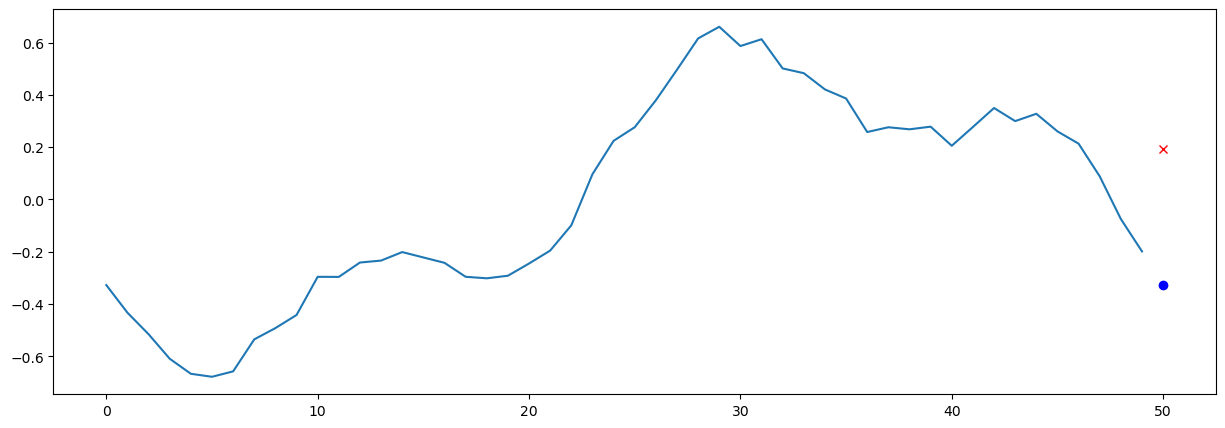

In [68]:
modelo = modelo_red_densa(X_train, y_train)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_densa = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

# Red Recurrente

## Red Recurrente de 1 Neurona

In [69]:
def modelo_red_recurrente_1(x_train, y_train):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[None, 1])
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model

Epoch 1/100
2/2 [==============================] - 1s 0s/step - loss: 0.1804
Epoch 2/100
2/2 [==============================] - 0s 0s/step - loss: 0.1764
Epoch 3/100
2/2 [==============================] - 0s 0s/step - loss: 0.1717
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1670
Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1621
Epoch 6/100
2/2 [==============================] - 0s 0s/step - loss: 0.1568
Epoch 7/100
2/2 [==============================] - 0s 0s/step - loss: 0.1515
Epoch 8/100
2/2 [==============================] - 0s 0s/step - loss: 0.1456
Epoch 9/100
2/2 [==============================] - 0s 0s/step - loss: 0.1395
Epoch 10/100
2/2 [==============================] - 0s 0s/step - loss: 0.1330
Epoch 11/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1265
Epoch 12/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1201
Epoch 13/100
2/2 [==============================] - 0s 16ms/step 

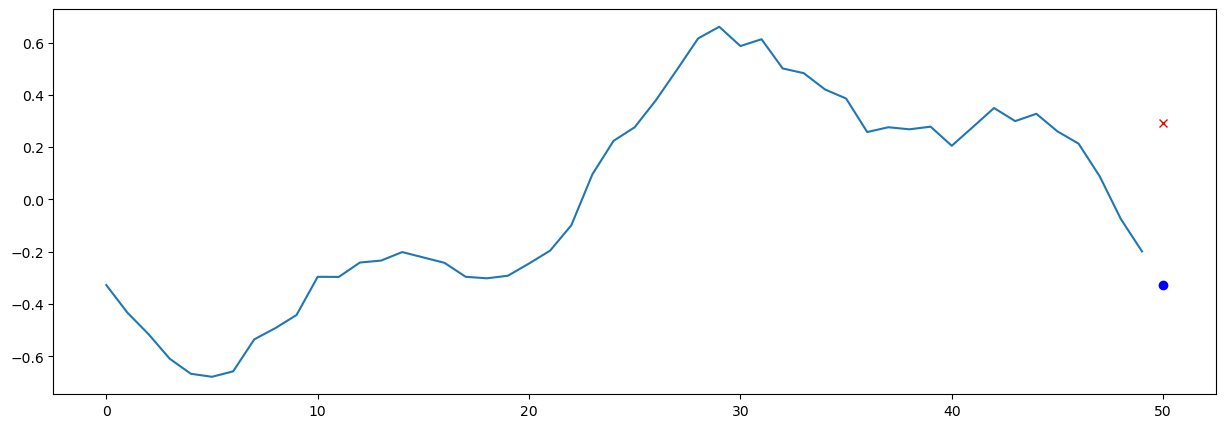

In [70]:
modelo = modelo_red_recurrente_1(X_train, y_train)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

In [71]:
modelo.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_19 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Modelo de varias neuronas

In [72]:
def modelo_red_recurrente_2(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False, input_shape=[None, 1]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=50)
    return model

Epoch 1/50
2/2 [==============================] - 1s 0s/step - loss: 0.2896
Epoch 2/50
2/2 [==============================] - 0s 3ms/step - loss: 0.0464
Epoch 3/50
2/2 [==============================] - 0s 0s/step - loss: 0.0276
Epoch 4/50
2/2 [==============================] - 0s 0s/step - loss: 0.0332
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0332
Epoch 6/50
2/2 [==============================] - 0s 0s/step - loss: 0.0207
Epoch 7/50
2/2 [==============================] - 0s 0s/step - loss: 0.0116
Epoch 8/50
2/2 [==============================] - 0s 0s/step - loss: 0.0115
Epoch 9/50
2/2 [==============================] - 0s 0s/step - loss: 0.0117
Epoch 10/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 11/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0056
Epoch 12/50
2/2 [==============================] - 0s 19ms/step - loss: 0.0041
Epoch 13/50
2/2 [==============================] - 0s 15ms/step - loss: 0.003

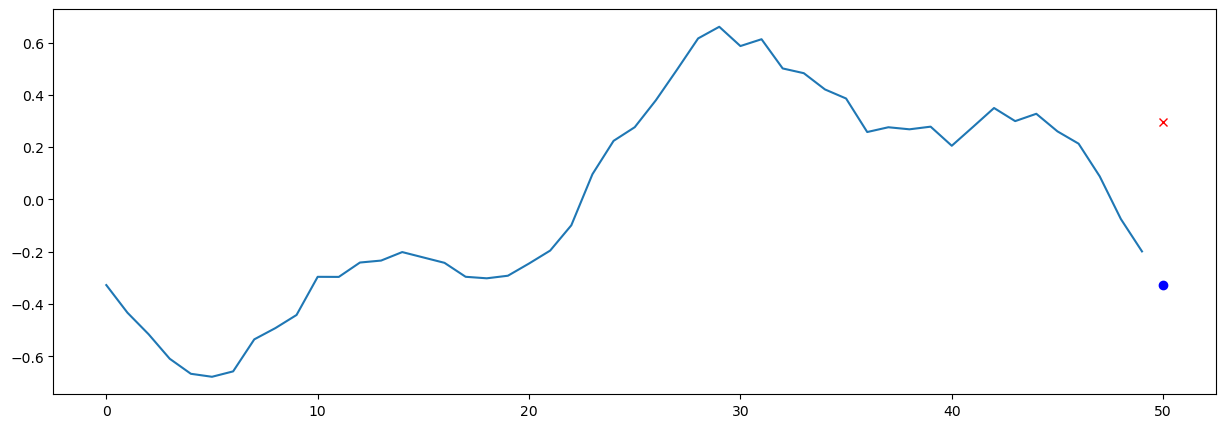

In [73]:
modelo = modelo_red_recurrente_2(X_train, y_train, 50)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )

## De 3 Capas

In [47]:
"""OJO CON EL RETURN_SEQUENCES"""
def modelo_red_recurrente_3(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False, input_shape=[None, 1]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=50)
    return model

Epoch 1/50
2/2 [==============================] - 2s 3ms/step - loss: 0.7471
Epoch 2/50
2/2 [==============================] - 0s 15ms/step - loss: 0.0372
Epoch 3/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1644
Epoch 4/50
2/2 [==============================] - 0s 16ms/step - loss: 0.0700
Epoch 5/50
2/2 [==============================] - 0s 18ms/step - loss: 0.0289
Epoch 6/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0388
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0162
Epoch 9/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0071
Epoch 10/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 11/50
2/2 [==============================] - 0s 10ms/step - loss: 0.0134
Epoch 12/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0123
Epoch 13/50
2/2 [==============================] - 0s 4ms/step -

array([[ 0.28476715],
       [ 0.18329142],
       [ 0.3061265 ],
       [ 0.3351422 ],
       [ 0.32366005],
       [ 0.35888034],
       [ 0.26975274],
       [ 0.18005161],
       [ 0.15333046],
       [-0.04240554]], dtype=float32)

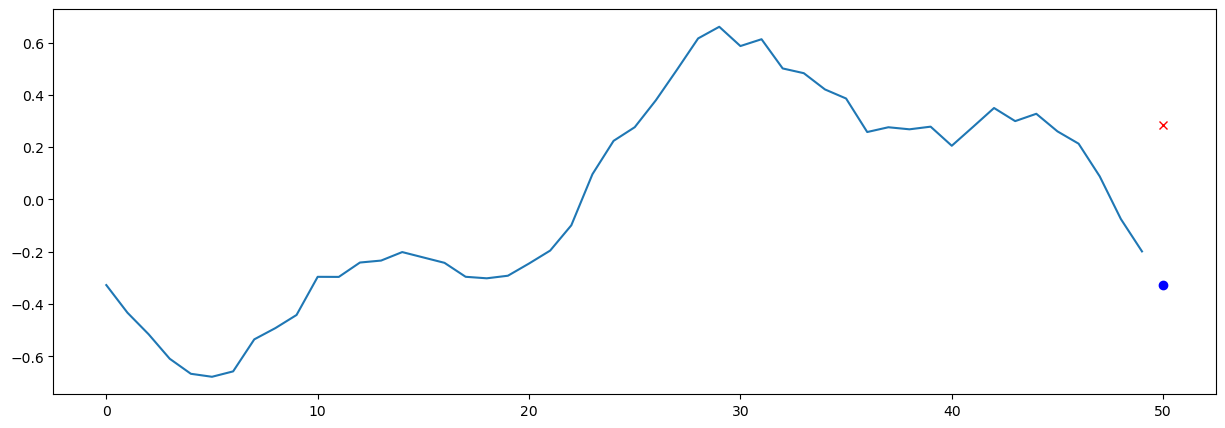

In [48]:
modelo = modelo_red_recurrente_3(X_train, y_train, 50)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")
plot_serie(X_train[0], lg_sec, y_train[0], y_pred[0] )
y_pred

## Predicción Multi valor

In [49]:
lg_y = 10
rnn_predice_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40),
    keras.layers.Dense(lg_y)
    ])
rnn_predice_10.compile(loss="mse", optimizer="adam")

In [50]:
lg_y = 10

x, y = genera_train(s1, lg_sec,  lg_y)
lim = int((len(x) * 0.8))
X_train, y_train = x[:lim], y[:lim]
X_test, y_test = x[lim:], y[lim:]


In [51]:
rnn_predice_10.fit(X_train, y_train,epochs=100)

Epoch 1/100


1/1 [==============================] - 1s 1s/step - loss: 0.4446
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2846
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.2200
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1882
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1618
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 0.1378
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1183
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1045
Epoch 9/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0944
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0854
Epoch 11/100
1/1 [==============================] - 0s 0s/step - loss: 0.0772
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0694
Epoch 13/100
1/1 [==============================] - 0s 18ms/step - loss

In [52]:
y_pred = rnn_predice_10.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms rnn_predice_10 = {rms}")

1/1 [==============================] - 0s 220ms/step
rms rnn_predice_10 = 0.06813393533229828


### Predecir 10 valores V2

In [53]:
# Por cada valor proporcionado, devuelve 10
lg_y = 10
lg_sec = 1
x, y = genera_train(s1, lg_sec,  lg_y)
lim = int((len(x) * 0.8))
X_train, y_train = x[:lim], y[:lim]
X_test, y_test = x[lim:], y[lim:]


"""EN ESTE SE VA BASAR EN SU PROPIO DATO PARA GENERAR EL SIGUIENTE PARA CONTINUAR"""
rnn_predice_1_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.Dense(lg_y)
    ])
rnn_predice_1_10.compile(loss="mse", optimizer="adam")
rnn_predice_1_10.fit(X_train, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 2s 2ms/step - loss: 0.1476
Epoch 2/100
3/3 [==============================] - 0s 0s/step - loss: 0.1429
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1407
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1384
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1383
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1373
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1373
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.1364
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.1364
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 0.1357
Epoch 11/100
3/3 [==============================] - 0s 0s/step - loss: 0.1362
Epoch 12/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1359
Epoch 13/100
3/3 [==============================] - 0s 3ms/ste

In [54]:
y_pred = rnn_predice_10.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], -1)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms rnn_predice_10 = {rms}")

y_pred

1/1 [==============================] - 0s 227ms/step
rms rnn_predice_10 = 0.3709399104118347


array([[-0.0275484 , -0.01353051,  0.03809096, -0.02200613, -0.08394729,
        -0.02470477, -0.05694214, -0.01260185,  0.09949008, -0.03762409],
       [-0.0153307 ,  0.00715932,  0.04875922, -0.00812704, -0.05568802,
        -0.00399937, -0.02760453, -0.00289502,  0.05122443, -0.00917745],
       [-0.00523545,  0.02421473,  0.05752287,  0.00336973, -0.03232627,
         0.012998  , -0.00322152,  0.00514856,  0.01106666,  0.01447285],
       [ 0.00833906,  0.04698781,  0.06920849,  0.01874507, -0.00099291,
         0.0357637 ,  0.029389  ,  0.01590295, -0.04263318,  0.04609054],
       [ 0.02471817,  0.07406108,  0.08312289,  0.03696971,  0.03653624,
         0.06321259,  0.06785944,  0.02863457, -0.10585859,  0.0833318 ],
       [ 0.03676879,  0.093595  ,  0.0932112 ,  0.05002256,  0.06384533,
         0.08346751,  0.09516417,  0.0377326 , -0.15058142,  0.10970103],
       [ 0.03850918,  0.09638472,  0.09465702,  0.05187742,  0.06776296,
         0.08639989,  0.09902149,  0.03902336